### Used to train our current model
Currently deployed on our API

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Import Libraries
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:
print(tf.__version__)

2.11.0


In [6]:
IMG_HEIGHT = 1008
IMG_WIDTH = 756
BATCH_SIZE = 16



TRAINING_DATA = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/arcData/Front",
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=0.1,
    subset="training",
    seed=1024
)

VALIDATION_DATA = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/arcData/Front",
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=0.1,
    subset="validation",
    seed=1024
)



TRAINING_LABELS = TRAINING_DATA.map(lambda image, label: label)
VALIDATION_LABELS = VALIDATION_DATA.map(lambda image, label: label)







Found 2048 files belonging to 51 classes.
Using 1844 files for training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 2048 files belonging to 51 classes.
Using 204 files for validation.


In [7]:
print("Training images shape : ",TRAINING_DATA.element_spec[0].shape)
print("Training labels shape : ",TRAINING_LABELS.element_spec.shape)
print("Validation images shape : ",VALIDATION_DATA.element_spec[0].shape)
print("Validation labels shape : ",VALIDATION_LABELS.element_spec.shape)

Training images shape :  (None, 1008, 756, 3)
Training labels shape :  (None, 51)
Validation images shape :  (None, 1008, 756, 3)
Validation labels shape :  (None, 51)


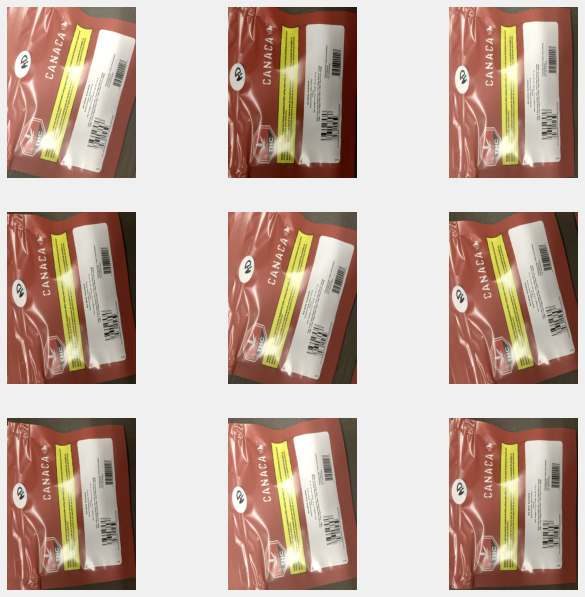

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=(-0.05, 0.05)),
        layers.RandomZoom((-0.05,-0.15),(-0.05,-0.15)),
        tf.keras.layers.RandomBrightness(factor=0.1),
        tf.keras.layers.RandomBrightness(factor=0.1)  
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in TRAINING_DATA.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
# Apply `data_augmentation` to the training images.
TRAINING_DATA = TRAINING_DATA.map(
   lambda img, label: (data_augmentation(img), label),
   num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
TRAINING_DATA = TRAINING_DATA.prefetch(tf.data.AUTOTUNE)
VALIDATION_DATA = VALIDATION_DATA.prefetch(tf.data.AUTOTUNE)

In [10]:
#Build Model
MODEL = tf.keras.Sequential(
    [
      
        #Rescale the images from 0-255 to 0-1 to make it easier to process
        tf.keras.layers.Rescaling(1./255),
        
        #Convolutional Layer 1
        tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer
   
        #Convolutional Layer 2
        tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer

        #Convolutional Layer 3
        tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer

        #Flatten the data for the Dense Layers
        tf.keras.layers.Flatten(),
        
        #Dense Layer 1
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),



        
        # This dense layer must contain the number of subdirectories
        # ex) if categories are cats and dogs, x = 2
        # ex) if categories are cats dogs, and birds x = 3     
     #TO DO: change to a integer variable of the number of subdirectories
        #Dense Layer 2
        tf.keras.layers.Dense(51)
     

     


    ]
)
MODEL.add(tf.keras.layers.Activation('softmax'))





In [11]:
#Compile Model/Preprocess Model
MODEL.compile(
    optimizer='adam',
    loss = tf.losses.categorical_crossentropy,
    metrics=['accuracy']
    
)


In [12]:
#Getting Log Data
# We can hopefully see how it works easier with this
NAME = "cannabis-packaging-756x1008-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [13]:
#Train Model
#This is where we can change the number of times it runs
MODEL.fit(
   TRAINING_DATA,
    epochs=10, 
    callbacks=[tensorboard],
    validation_data = VALIDATION_DATA
)

Epoch 1/10
116/116 [==============================] - 126s 931ms/step - loss: 3.7578 - accuracy: 0.4154 - val_loss: 1.9355 - val_accuracy: 0.7500
Epoch 2/10
116/116 [==============================] - 58s 464ms/step - loss: 1.3637 - accuracy: 0.8796 - val_loss: 1.2294 - val_accuracy: 0.8824
Epoch 3/10
116/116 [==============================] - 58s 457ms/step - loss: 1.1017 - accuracy: 0.9306 - val_loss: 1.0887 - val_accuracy: 0.9216
Epoch 4/10
116/116 [==============================] - 58s 467ms/step - loss: 1.0693 - accuracy: 0.9203 - val_loss: 1.3793 - val_accuracy: 0.8235
Epoch 5/10
116/116 [==============================] - 59s 477ms/step - loss: 0.9264 - accuracy: 0.9474 - val_loss: 0.9081 - val_accuracy: 0.9314
Epoch 6/10
116/116 [==============================] - 58s 460ms/step - loss: 1.0103 - accuracy: 0.9100 - val_loss: 1.3632 - val_accuracy: 0.8480
Epoch 7/10
116/116 [==============================] - 58s 453ms/step - loss: 1.0314 - accuracy: 0.9252 - val_loss: 0.9402 - val_a

In [14]:
MODEL.evaluate(VALIDATION_DATA)

13/13 [==============================] - 3s 91ms/step - loss: 0.7474 - accuracy: 0.9510


[0.747412383556366, 0.9509803652763367]

In [15]:
MODEL.save("ARC_Model_Front_3.h5")

In [16]:
new_model = tf.keras.models.load_model("ARC_Model_Front_3.h5")

In [17]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1008, 756, 3)      0         
                                                                 
 conv2d (Conv2D)             (None, 1006, 754, 32)     896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 503, 377, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 501, 375, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 187, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 248, 185, 32)     

In [22]:
import os
import numpy as np
from PIL import Image
# import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

DATADIR = "/content/drive/MyDrive/arcData/Front"
CATEGORIES = os.listdir(DATADIR)

# Define the directory containing the test images
TEST_DIR = '/content/drive/MyDrive/arcData/static'

# Get the list of image file names
file_name = 'IMG_5429.JPG'

# Initialize an empty array to store the preprocessed images
X_test = np.zeros((1, 1008, 756, 3), dtype=np.float32)



# Load the image
img = Image.open(os.path.join(TEST_DIR, file_name))
img = img.resize((756, 1008))


# Convert the image to a NumPy array and scale the pixel values to [0, 1]
img_array = img_to_array(img)


# Add the preprocessed image to the array
X_test[0] = img_array


# Load the Keras model
model = load_model('/content/ARC_Model_Front_3.h5')

# Make predictions on the test images
y_pred = model.predict(X_test)


# Get the predicted class label and confidence
class_label = CATEGORIES[np.argmax(y_pred)]
confidence = y_pred[0][np.argmax(y_pred)]

# Print the predicted class label and confidence
print('Predicted class label:', class_label)
print('Confidence:', confidence)




1/1 [==============================] - 0s 101ms/step
Predicted class label: UP20_GhostTrainHaze_3g_Front
Confidence: 0.9999912
